In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.pandas.set_option("display.max_columns", None)

In [14]:
df = pd.read_csv(r"EasyVisa.csv")

In [15]:
# Check null values
faetures_with_na = [features for features in df.columns if df[features].isnull().sum()>=1]
for feature in faetures_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), '% missing values')

In [16]:
faetures_with_na

[]

In [17]:
# handling duplicates
df.duplicated().sum()

np.int64(0)

In [18]:
df.drop('case_id', inplace=True, axis=1)

## Feature engineering

In [19]:
# feature extraction
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [20]:
from datetime import date

todays_date = date.today()
current_year = todays_date.year 

current_year

2024

In [21]:
df['company_age'] = current_year - df['yr_of_estab']

In [22]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,17
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,22
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,16
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,127
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,19


In [23]:
df.drop('yr_of_estab', axis=1, inplace=True)

#### Type of features

In [24]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical features:', len(num_features))

Num of Numerical features: 3


In [25]:
cat_features = [feature for feature in df.columns if df[feature].dtype =='O']
print('Num of categorical features:', len(cat_features))

Num of categorical features: 8


In [26]:
discrete_features = [feature for feature in num_features if len(df[feature].unique()) <= 25]
print('Num of discrete features: ', len(discrete_features))

Num of discrete features:  0


In [27]:
continuous_features = [feature for feature in num_features if len(df[feature].unique()) > 25]
print('Num of continuous features: ', len(continuous_features))

Num of continuous features:  3


### Split X & Y

In [28]:
X = df.drop('case_status', axis=1)
y = df['case_status']

In [29]:
y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [30]:
# manually encoding target column
y = np.where(y=='Denied', 1, 0)
y 

array([1, 0, 1, ..., 0, 0, 0])

### Feature Transformation 

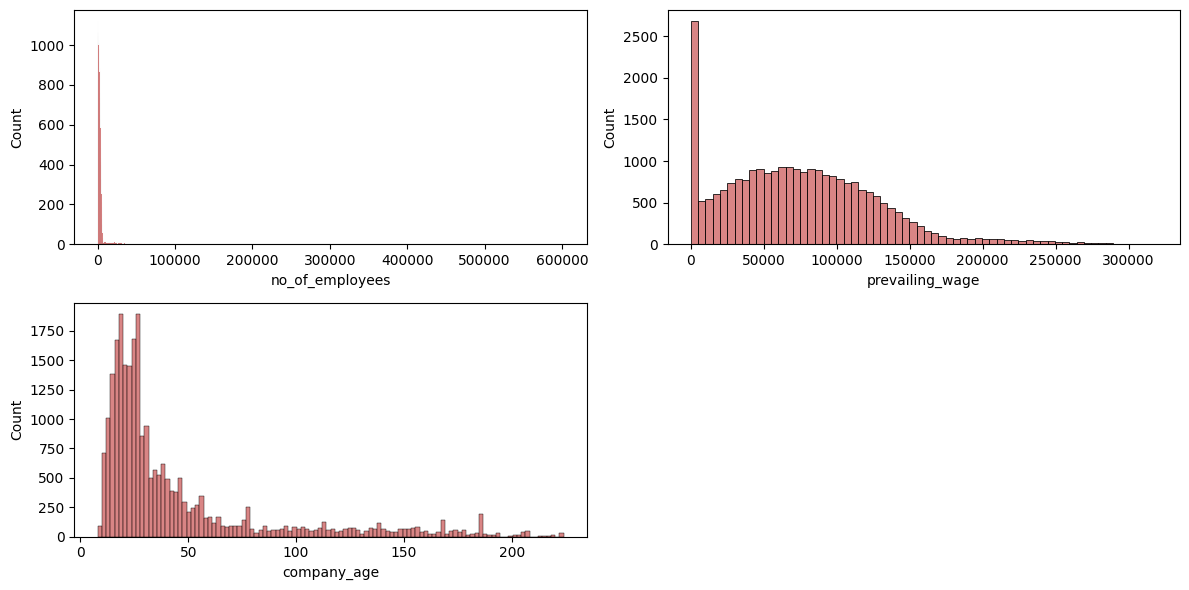

In [31]:
# check distributio of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['no_of_employees', 'prevailing_wage', 'company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [32]:
# Checking skewness
X[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

### Apply Power Transformer to check if it can reduces the outliers

In [33]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [34]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

In [35]:
X_copy.skew(axis=0, skipna=True)

company_age        0.103264
no_of_employees    0.399339
dtype: float64

#### Preprocessing using column transformer

In [36]:
# create column transformer with 3 types of transformers

or_columns = ['has_job_experience', 'requires_job_training', 'full_time_position', 'education_of_employee']
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment']
transform_columns = ['no_of_employees', 'company_age']

In [37]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(
    steps=[
        ('tranfomer', PowerTransformer(method='yeo-johnson'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [38]:
X = preprocessor.fit_transform(X)

In [39]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

## Classification

In [40]:
from imblearn.combine import SMOTETomek, SMOTEENN

# resampling the minority class, the strategy can be changed as required
smt = SMOTEENN(random_state=42, sampling_strategy='minority')

# fit the model to generate the data
X_res, y_res = smt.fit_resample(X, y)


### Train Test split

In [41]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [43]:
def evaluate_clf(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    return acc, f1, precision, recall, roc_auc

In [44]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "Support Vector Classifer": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    #"CatBoostClassifier": CatBoostClassifier()
}

In [55]:
# Create a function which can evaluate models and return report
def evaluate_models(X, y, models):
    '''
    This function takes X and y and modeks dictionary as input
    It spluts the data into Train test split
    Iterates through the given model dictionary and evaluates the metrics
    returns: DataFrame which contains report of all models metrics with cost
    ''' 
    # Separate the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []
    auc = []

    for i in range (len(list(models))):
        clf = list(models.values())[i]
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        acc_tr, f1_tr, precision_tr, recall_tr, roc_auc_score_tr = evaluate_clf(y_train, y_train_pred)
        acc_te, f1_te, precision_te, recall_te, roc_auc_score_te = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for training set')
        print('- Accuracy: {:.4f}'.format(acc_tr))
        print('- Precision: {:.4f}'.format(precision_tr))
        print('- Recall: {:.4f}'.format(recall_tr))
        print('- F1-score: {:.4f}'.format(f1_tr))
        print('- ROC AUC Score: {:.4f}'.format(roc_auc_score_tr))

        print('==============================================')

        print('Model performance for test set')
        print('- Accuracy: {:.4f}'.format(acc_te))
        print('- Precision: {:.4f}'.format(precision_te))
        print('- Recall: {:.4f}'.format(recall_te))
        print('- F1-score: {:.4f}'.format(f1_te))
        print('- ROC AUC Score: {:.4f}'.format(roc_auc_score_te))
        print('----------------------------------------')

        accuracy_list.append(acc_te)
        auc.append(roc_auc_score_te)
        

    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

    return report

In [56]:
# Model Training
base_model_report = evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-score: 1.0000
- ROC AUC Score: 1.0000
Model performance for test set
- Accuracy: 0.9548
- Precision: 0.9574
- Recall: 0.9594
- F1-score: 0.9584
- ROC AUC Score: 0.9544
----------------------------------------
Decision Tree
Model performance for training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-score: 1.0000
- ROC AUC Score: 1.0000
Model performance for test set
- Accuracy: 0.9305
- Precision: 0.9343
- Recall: 0.9378
- F1-score: 0.9360
- ROC AUC Score: 0.9298
----------------------------------------
Gradient Boosting
Model performance for training set
- Accuracy: 0.8822
- Precision: 0.8945
- Recall: 0.8862
- F1-score: 0.8903
- ROC AUC Score: 0.8819
Model performance for test set
- Accuracy: 0.8956
- Precision: 0.9095
- Recall: 0.8967
- F1-score: 0.9031
- ROC AUC Score: 0.8955
----------------------------------------
Logistic Regression
Model performance f

In [57]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.954839
4,K-Neighbors Classifier,0.940176
5,XGBClassifier,0.935191
1,Decision Tree,0.930499
2,Gradient Boosting,0.895601
6,Support Vector Classifer,0.870088
7,AdaBoost Classifier,0.868328
3,Logistic Regression,0.745161


In [58]:
# We can use Random Forest for Hyper parameter Training
xgboost_params = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [10, 12, None, 15, 20],
    'max_features': ['sqrt', 'log2', None],
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [60]:
# model list for hyper param tuning
randomcv_models = [
    ('RandomForest', RandomForestClassifier(), rf_params),
    ('XGBoost', XGBClassifier(), xgboost_params),
    ('KNN', KNeighborsClassifier(), knn_params)
]

In [61]:
from sklearn.model_selection import RandomizedSearchCV

model_params = {}
for name, model, params in randomcv_models:
    random_search = RandomizedSearchCV(model, params, cv=5, n_iter=5, random_state=42, n_jobs=-1)
    random_search.fit(X_res, y_res)
    model_params[name] = random_search.best_params_
    print(f'{name} best parameters: {random_search.best_params_}')

for model_name in model_params:
    print(f"----------- Best parameters for {model_name} --------------------")
    print(model_params[model_name])
    

RandomForest best parameters: {'n_estimators': 50, 'max_features': None, 'max_depth': 15}
XGBoost best parameters: {'min_child_weight': 1, 'max_depth': 9}
KNN best parameters: {'weights': 'distance', 'n_neighbors': 7, 'algorithm': 'ball_tree'}
----------- Best parameters for RandomForest --------------------
{'n_estimators': 50, 'max_features': None, 'max_depth': 15}
----------- Best parameters for XGBoost --------------------
{'min_child_weight': 1, 'max_depth': 9}
----------- Best parameters for KNN --------------------
{'weights': 'distance', 'n_neighbors': 7, 'algorithm': 'ball_tree'}


In [62]:
model_params

{'RandomForest': {'n_estimators': 50, 'max_features': None, 'max_depth': 15},
 'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'KNN': {'weights': 'distance', 'n_neighbors': 7, 'algorithm': 'ball_tree'}}

In [63]:
# Retraining model with best parameters
from sklearn.metrics import roc_auc_score, roc_curve
best_models = {
    'RandomForest': RandomForestClassifier(**model_params['RandomForest']),
    'XGBoost': XGBClassifier(**model_params['XGBoost'], n_jobs=-1),
    'KNN': KNeighborsClassifier(**model_params['KNN']),
}

tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)

RandomForest
Model performance for training set
- Accuracy: 0.9855
- Precision: 0.9789
- Recall: 0.9946
- F1-score: 0.9866
- ROC AUC Score: 0.9847
Model performance for test set
- Accuracy: 0.9361
- Precision: 0.9349
- Recall: 0.9481
- F1-score: 0.9415
- ROC AUC Score: 0.9350
----------------------------------------
XGBoost
Model performance for training set
- Accuracy: 0.9995
- Precision: 0.9993
- Recall: 0.9997
- F1-score: 0.9995
- ROC AUC Score: 0.9995
Model performance for test set
- Accuracy: 0.9455
- Precision: 0.9487
- Recall: 0.9508
- F1-score: 0.9498
- ROC AUC Score: 0.9450
----------------------------------------
KNN
Model performance for training set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-score: 1.0000
- ROC AUC Score: 1.0000
Model performance for test set
- Accuracy: 0.9525
- Precision: 0.9391
- Recall: 0.9757
- F1-score: 0.9570
- ROC AUC Score: 0.9504
----------------------------------------


In [64]:
tuned_report

,Model Name,Accuracy
2,KNN,0.952493
1,XGBoost,0.945455
0,RandomForest,0.936070


In [65]:
best_model = KNeighborsClassifier(**model_params['KNN'])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL 'KNN'")
print("Accuracy Score: {:.4f}".format(score))
print(cr)

FINAL MODEL 'KNN'
Accuracy Score: 0.9525
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1561
           1       0.94      0.98      0.96      1849

    accuracy                           0.95      3410
   macro avg       0.95      0.95      0.95      3410
weighted avg       0.95      0.95      0.95      3410



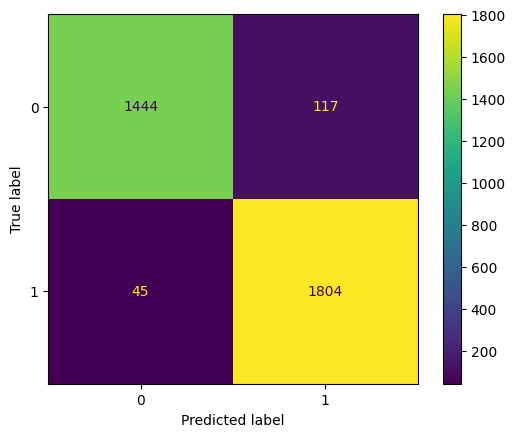

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()